In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

import pickle

# Looking at the production model

In [2]:
production_model = pickle.load(open('../models/poly_data_lasso_model.sav', 'rb'))

In [3]:
features = np.load('../datasets/polynomial_features_for_modeling.npy')

In [4]:
# The production model's r2score 
production_model_score = np.load('../datasets/lasso_poly_r2score.npy')
production_model_score

array([0.91306444])

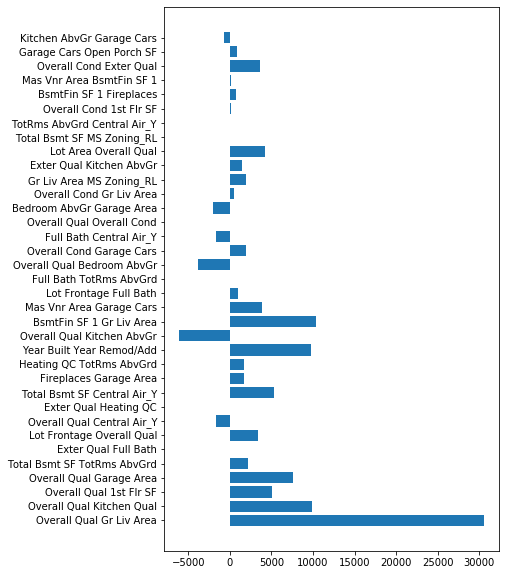

In [5]:
plt.figure(figsize=(6, 10));
plt.barh(features, production_model.coef_);

In [6]:
# Sorts the coef order
model_coef_sort = production_model.coef_.copy()
features_sort = list(features.copy())
change = True
while change:
    change = False
    for i in range(len(production_model.coef_) - 1):
        if model_coef_sort[i] > model_coef_sort[i + 1]:
            model_coef_sort[i], model_coef_sort[i + 1] = model_coef_sort[i + 1], model_coef_sort[i]
            features_sort[i], features_sort[i + 1] = features_sort[i + 1], features_sort[i]
            change = True

Text(0.5, 1.0, 'The coefficients for the production model')

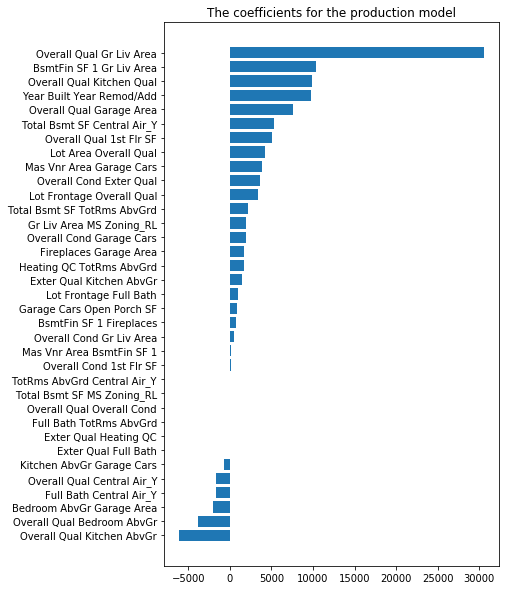

In [7]:
plt.figure(figsize=(6, 10));
plt.barh(features_sort, model_coef_sort);
plt.title('The coefficients for the production model')

##### The model R^2 score is about 0.91. 
##### From the graph, the high coefficients have the Overall Qual. In addtion, some house size indecations  such as the Gr Liv Area, the Garage Area, etc. have high coefficieats, too。And the newer the better. Therefore, it is essential to make the house quality higher, make the house bigger, and keep the house newer by remodeling for the sales price.
##### I think this production model can be applied to a similar city to Ames. If this model would be applied for a different type of city,  the score would be lower. For example, only about 8 % people use public transportation in Ames, whereas about 50 % peaple use it in New York (*1, *2). In a different city, the Garage Size in the model might weigh lower. Moreover, the median property value in Ames is 187,000 dollars, whereas the median property value in New York is 604,000 dollars (*1, *2). This would lead the model coefficient weghts different.

### This model doesn't have the information where a house is to explain the SalePrice. So check the effect adding the neighborhood.

In [8]:
train = pd.read_csv('../datasets/train_engineered_just_category.csv')
poly_train = pd.read_csv('../datasets/train_polynomial.csv')

In [9]:
train.groupby('Neighborhood')['SalePrice'].median().sort_values()

Neighborhood
MeadowV     92450
IDOTRR     102000
BrDale     105500
OldTown    120000
Edwards    123500
BrkSide    128000
Sawyer     135000
SWISU      136200
Landmrk    137000
Blueste    137500
NAmes      141000
NPkVill    143000
Mitchel    160000
Gilbert    180500
SawyerW    181000
NWAmes     185000
Greens     190000
Blmngtn    192250
Crawfor    198750
CollgCr    200000
Timber     220000
Somerst    224000
ClearCr    225000
Veenker    265000
GrnHill    280000
StoneBr    282000
NoRidge    300000
NridgHt    315500
Name: SalePrice, dtype: int64

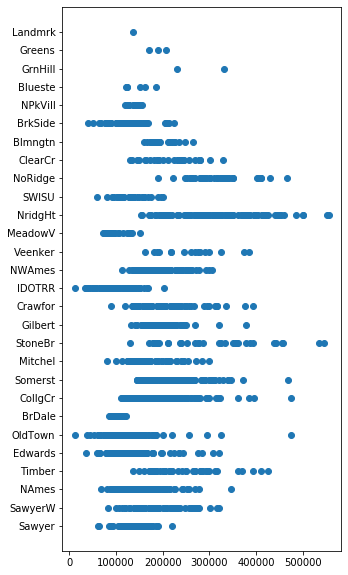

In [10]:
plt.figure(figsize=(5, 10))
plt.scatter(train['SalePrice'], train['Neighborhood']);

In [11]:
# split into 3 labels basing on the salePrice
neighbor_median_price = train.groupby('Neighborhood')['SalePrice'].median().sort_values()
less_140000 = [key for key, val in neighbor_median_price.items() if val < 140000]
more_140000_less_200000 = [key for key, val in neighbor_median_price.items() if (val >= 140000) & (val < 200000)]
more_200000 = [key for key, val in neighbor_median_price.items() if val >= 200000]

def allocate_neighborhood(data):
    if data in less_140000:
        return 0
    if data in more_140000_less_200000:
        return 1
    if data in more_200000:
        return 2
    

In [12]:
poly_train['neighborhood_price_class'] = train['Neighborhood'].apply(lambda x: allocate_neighborhood(x))

In [13]:
poly_train['neighborhood_price_class']

0       0
1       1
2       1
3       2
4       1
       ..
2013    2
2014    0
2015    1
2016    1
2017    1
Name: neighborhood_price_class, Length: 2018, dtype: int64

In [14]:
features = np.append(features, 'neighborhood_price_class')

In [15]:
X = poly_train[features]
y = train['SalePrice']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
l_alphas = np.logspace(0, 5, 1000)
lasso = LassoCV(alphas=l_alphas, cv=5)

lasso.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e+00, 1.01159111e+00, 1.02331658e+00, 1.03517796e+00,
       1.04717682e+00, 1.05931476e+00, 1.07159340e+00, 1.08401436e+00,
       1.09657929e+00, 1.10928986e+00, 1.12214777e+00, 1.13515471e+00,
       1.14831241e+00, 1.16162263e+00, 1.17508713e+00, 1.18870770e+00,
       1.20248614e+00, 1.21642429e+00, 1.23052400e+00, 1.24478715e+00,
       1.25921561e+00, 1.27381132e+0...
       8.80937190e+04, 8.91148232e+04, 9.01477631e+04, 9.11926760e+04,
       9.22497005e+04, 9.33189772e+04, 9.44006479e+04, 9.54948564e+04,
       9.66017480e+04, 9.77214697e+04, 9.88541702e+04, 1.00000000e+05]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [19]:
lasso.score(X_train, y_train)

0.922418176478148

In [20]:
production_model_score

array([0.91306444])

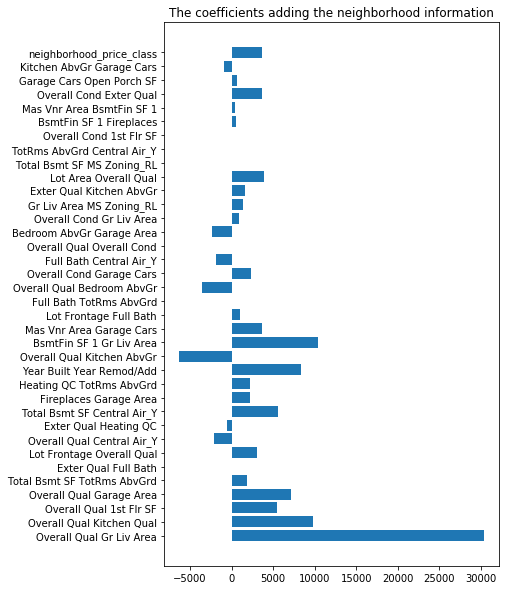

In [21]:
plt.figure(figsize=(6, 10));
plt.barh(X.columns, lasso.coef_);
plt.title('The coefficients adding the neighborhood information');

##### The score was refined adding the neighborhood information. But the variable I used for the model was just the classified feature basing of the sale price. There might be better features accociated with neighborhood information for the model. According to a paper, neighborhood charastaristic certainly affects the house price (* 3). In fact, as I mentioned above, the distance to a station would affect the saleprice in New York. In addition, crime rates affect house price (* 4).  So I suggest that to improve the house price predictions, it's important to gather more neighborhood data such as the ditance to a station, the number of public facilities, crime rates and so on. 


# Summary

- The model is good to predict the sale price in Ames since the R^2 score is about 0.91.
- This model can be applied to other cities similar to Ames.
- If this model would be applied to other places like New York, the model should be trained for the place's data since their city charastaristics are different.
- Neiborhood information should be important for a better model to predict house prices.
- The neiborhood data improve the model.
- It would be better to gather more neiborhood data such as distance to a station, crime rates, etc. to create a better model.

# Refference

- *1 https://datausa.io/profile/geo/ames-ia/#housing
- *2 https://datausa.io/profile/geo/new-york-ny#housing
- *3 https://www.researchgate.net/publication/304597534_THE_IMPACT_OF_NEIGHBORHOOD_CHARACTERISTICS_ON_HOUSING_PRICESAN_APPLICATION_OF_HIERARCHICAL_LINEAR_MODELING

- *4 https://born2invest.com/articles/neighborhood-safety-influencing-price-properties/
- *5 https://www.neighborhoodscout.com/ia/ames/crime